In [1]:
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast

#load data
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

#data cleaning
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
#filtering data
df_CZ = df[df['job_country']=='Czechia'].copy()
df_SK = df[df['job_country']=='Slovakia'].copy()
#replacing inconsistent values
df_CZ['job_location'] = df_CZ['job_location'].replace({'Czechia': 'Czechia Remote', 'Anywhere': 'Czechia Remote'})
df_SK['job_location'] = df_SK['job_location'].replace({'Slovakia': 'Slovakia Remote', 'Anywhere': 'Slovakia Remote'})
#concatinating the dataframes
df_CZSK = pd.concat([df_CZ, df_SK], ignore_index=True)

In [3]:
df_skills = df_CZSK.explode('job_skills')

In [4]:
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()
df_skills_count = df_skills_count.reset_index(name='skill_count')
df_skills_count.sort_values(by='skill_count',ascending=False, inplace=True)

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()
job_titles = sorted(job_titles[:3])

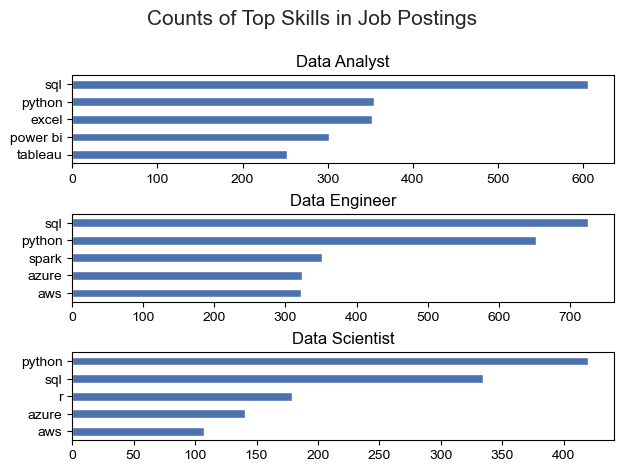

In [6]:
fig, ax = plt.subplots(len(job_titles),1)

sns.set_theme(style='ticks')

for i, job_title in enumerate (job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)
    df_plot.plot(kind='barh', x='job_skills', y='skill_count', ax=ax[i], title=job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].legend().set_visible(False)

fig.suptitle('Counts of Top Skills in Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5)
plt.show()

In [7]:
df_job_title_count = df_CZSK['job_title_short'].value_counts().reset_index(name='jobs_total')
df_skills_pct = pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short')
df_skills_pct['skill_percent'] = 100*df_skills_pct['skill_count']/df_skills_pct['jobs_total']
df_skills_pct

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,726,1089,66.666667
1,python,Data Engineer,652,1089,59.871442
2,sql,Data Analyst,606,1174,51.618399
3,python,Data Scientist,420,696,60.344828
4,python,Software Engineer,358,927,38.619202
...,...,...,...,...,...
1129,watson,Senior Data Scientist,1,141,0.709220
1130,watson,Data Engineer,1,1089,0.091827
1131,atlassian,Senior Data Analyst,1,138,0.724638
1132,aurora,Business Analyst,1,626,0.159744


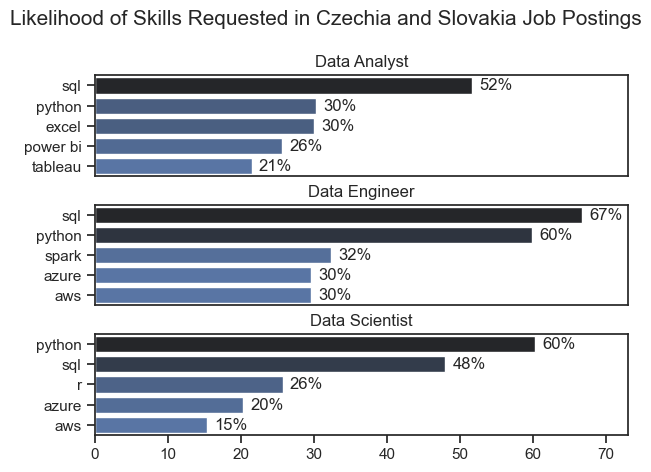

In [8]:
fig, ax = plt.subplots(len(job_titles),1)

sns.set_theme(style='ticks')

for i, job_title in enumerate (job_titles):
    df_plot = df_skills_pct[df_skills_pct['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0,73)

    for n, v in enumerate (df_plot['skill_percent']):
        ax[i].text(v+1, n, f'{v:.0f}%', va='center')
    if i !=len(job_titles) - 1:
        ax[i].set_xticks([])

fig.suptitle('Likelihood of Skills Requested in Czechia and Slovakia Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5)
plt.show()